# The final DpoDetection Tool :
***

In [8]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/"
DpoDetection_path = f"{path_work}/DepoDetection.t12_30M.conv2L.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  
        self.fc1 = nn.Linear(64 * (self.max_length - (5 - 1)), 32)  
        self.classifier = nn.Linear(32, 2)

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) 
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  
        outputs = outputs.float()  
        
        out = F.relu(self.conv1(outputs))
        out = out.view(batch_size, -1)
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [10]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0): EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False

In [11]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [17]:
def predict_sequence(model, sequence , name = ""):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list , name


(1, 0.9994138479232788) BAQ02837.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.99998939037323) AWD93192.1 tail spike protein [Acinetobacter phage vB_AbaM_B9]
(1, 0.9999077320098877) BAQ02839.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.9999507665634155) QDF14644.1 tail fiber protein [Klebsiella phage SH-KP152226]
(1, 0.9996352195739746) QEP53229.1 tailspike protein [Acinetobacter phage BS46]
(1, 0.9998965263366699) BBF66868.1 phage T7 tail fibre protein [Klebsiella phage KN3-1]
(1, 0.9999837875366211) QIW86428.1 tail spike [Klebsiella phage VLC5]
(1, 0.9999297857284546) APZ82847.1 tail fiber protein [Klebsiella phage K5-4]
(0, 0.9970245957374573) AVO22848.1 putative tail protein [Erwinia phage vB_EamM-Bue1]


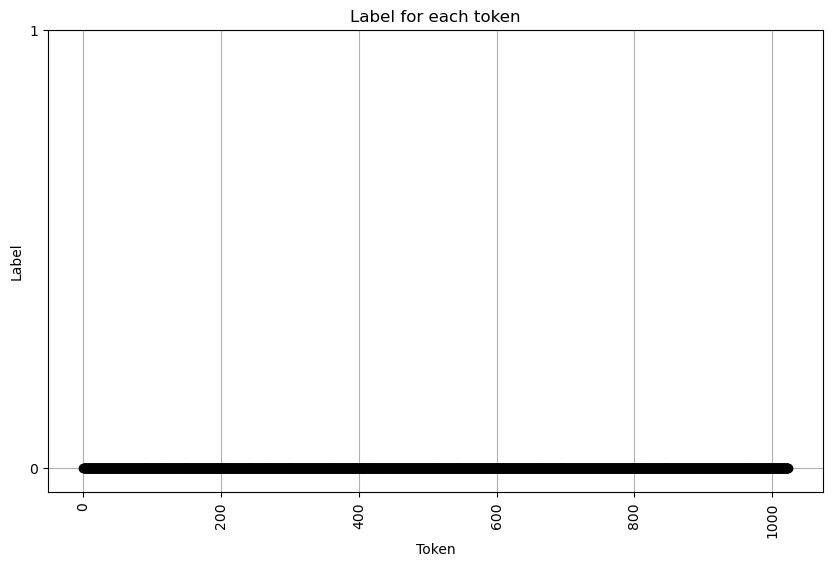

(1, 0.9999972581863403) YP_004678762.1 tail fiber protein [Escherichia phage K30]
(1, 0.9998804330825806) ARM70447.1 tail protein-depolymerase [Escherichia phage vB_EcoM_ECOO78]
(1, 0.9986044764518738) ALJ97635.1 tail fiber protein [Acinetobacter phage IME-200]
(1, 0.9997925162315369) BAQ02838.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.9983912110328674) ARV77571.1 tail fiber protein [Pasteurella phage vB_PmuP_PHB02]
(1, 0.9946452379226685) ATW62160.1 tailspike protein [Dickeya phage PP35]
(1, 0.8325029015541077) BAQ02844.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.9999507665634155) ALT58497.1 tail fibers protein [Klebsiella phage vB_KpnP_IME205]
(1, 0.9999889135360718) YP_009226011.1 tail protein [Klebsiella phage KP36]
(1, 0.9999773502349854) BBF66867.1 tail fibers protein [Klebsiella phage KN3-1]
(1, 0.9988607168197632) ALA12264.1 tail fiber [Acinetobacter phage phiAB6]
(1, 0.9998375177383423) APD20249.1 tailspike protein [Acinetobacter phage AM24]


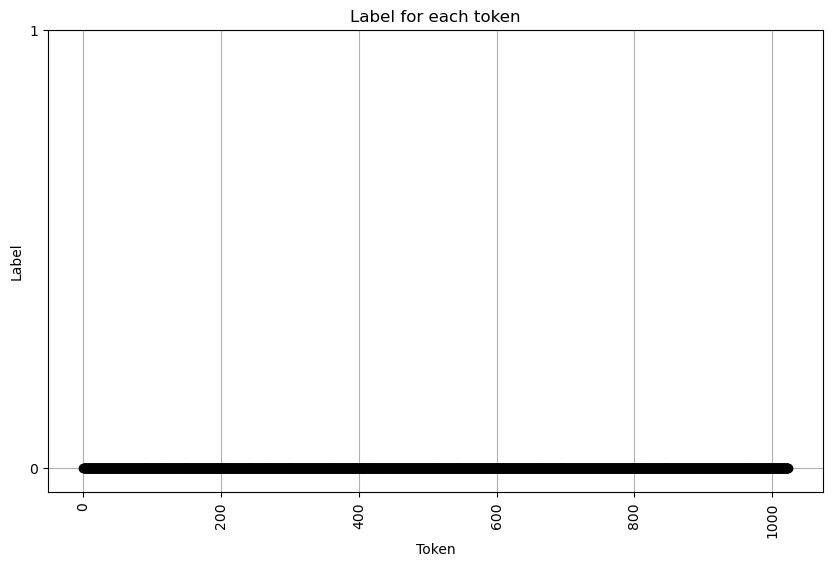

(1, 0.9999645948410034) APZ82768.1 putative tail fiber protein [Klebsiella phage vB_KpnP_KpV74]
(1, 0.9999673366546631) AOZ65519.1 putative tail fiber protein [Klebsiella phage vB_KpnP_KpV767]
(1, 0.9999145269393921) BAQ02836.1 tailspike protein [Klebsiella phage K64-1]
(1, 0.9999998807907104) BAQ02842.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.9999517202377319) APZ82804.1 tail fiber protein [Klebsiella phage K5-2]
(1, 0.9999878406524658) BAQ02841.1 putative tail fiber protein [Klebsiella phage K64-1]
(1, 0.999305248260498) YP_003347556.1 tail spike protein [Klebsiella phage KP32]
(1, 0.9999983310699463) BBF66888.1 hypothetical protein [Klebsiella phage KN4-1]
(1, 0.9243108630180359) BBF66844.1 tail spike protein [Klebsiella phage KN1-1]
(1, 0.9999018907546997) AGY48011.1 tail fiber protein [Acinetobacter phage Petty]
(1, 0.9990707039833069) AXE28435.1 tail fibers protein [Klebsiella phage vB_KpnP_IME321]
(1, 0.9999650716781616) ATI16495.1 tail fiber protein / pectate

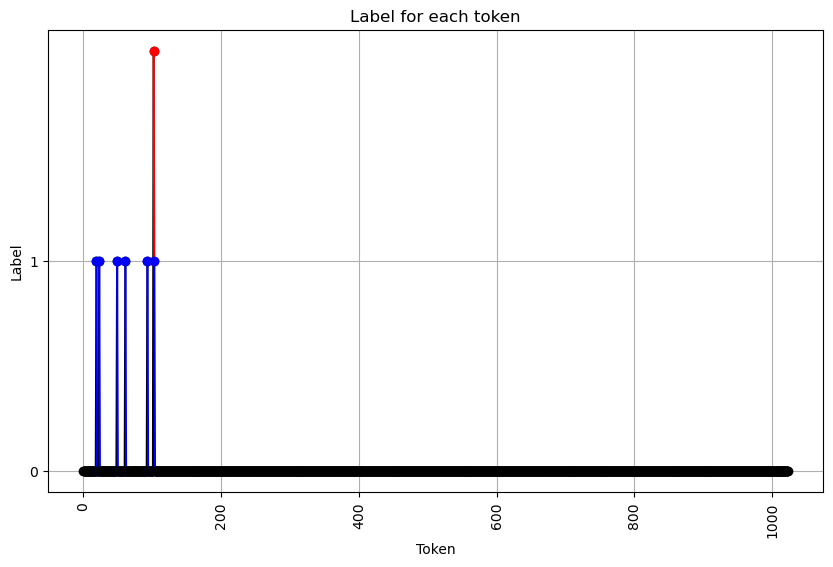

(0, 0.9970245957374573) AYP28214.1 putative tail fiber protein [Klebsiella phage GH-K3]


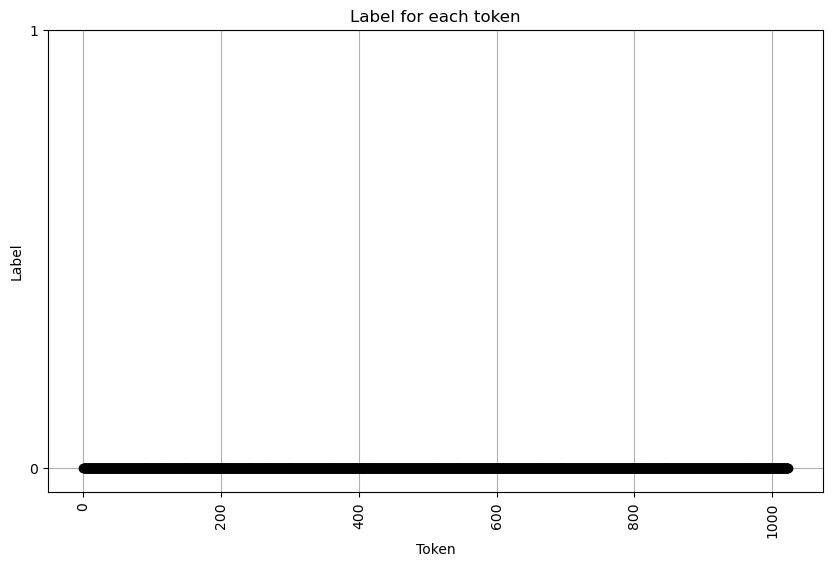

(1, 0.9999597072601318) QJI52632.1 tail spike [Klebsiella phage VLC6]
(1, 0.9999047517776489) YP_003347555.1 tail protein [Klebsiella phage KP32]
(1, 0.9999638795852661) AMQ66478.1 hypothetical protein kpv71_52 [Klebsiella phage KpV71]
(1, 0.9997625946998596) AUV57247.1 EPS depolymerase [Erwinia phage vB_EamP-S2]
(1, 0.9998358488082886) AYP68900.1 tail fiber protein [Acinetobacter phage vB_AbaM_IME285]
(1, 0.9998733997344971) BAQ02835.1 tail spike protein [Klebsiella phage K64-1]
(1, 0.9998257756233215) ALT58498.1 hypothetical protein [Klebsiella phage vB_KpnP_IME205]
(1, 0.9998364448547363) QIW86419.1 tail spike [Klebsiella phage VLC5]
(1, 0.9999949932098389) QHI00738.1 tail fibers protein [Escherichia phage vB_EcoP_PHB19]
(1, 0.9998310804367065) QJI52623.1 tail spike [Klebsiella phage VLC6]


In [19]:
from Bio import SeqIO


goldDpo_fasta = SeqIO.parse("/home/concha-eloko/Documents/GitHub/PhageDEPOdetection/data/GOLD_dpo.multi.fasta" , "fasta")

for record in goldDpo_fasta :
    prediction, sequence_outputs, name = predict_sequence(model_classifier, str(record.seq) , record.description)
    if prediction[0] == 0 :
        print(prediction , name)
        plot_token(sequence_outputs)
    else :
        print(prediction , record.description)

In [10]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)


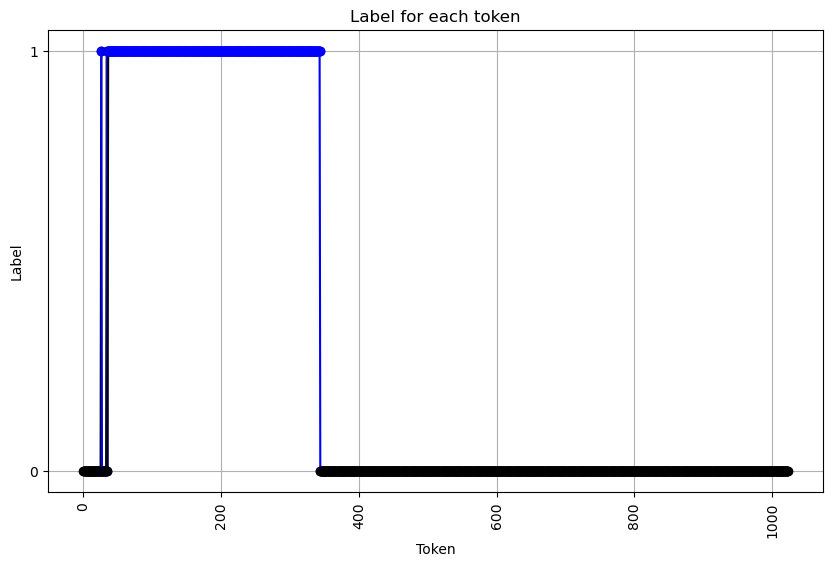

((1, 0.9974331259727478), None)

In [11]:
prediction  , plot_token(token)

In [8]:
token

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

***
# DpoDetectionTool BIG :

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
from Bio import SeqIO
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

esm2_model_path = "/home/conchae/PhageDepo_pdb/script_files/models/esm2_t30_150M_UR50D-finetuned-depolymerase/checkpoint-198"
DpoDetection_path = f"/home/conchae/PhageDepo_pdb/DepoDetection.t30_150M.conv2L.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

In [ ]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1026
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer 1 
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer 2
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 2)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [ ]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


In [ ]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [9]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)


>Move the sequences to the server : 

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/77_strains_phage_project/DetectedDpo.77_phages.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb 
    
rsync -avzhe ssh \
/media/concha-eloko/Linux/77_strains_phage_project/MissedDpos.77_phages.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb 


In [ ]:
fasta_1 = "/home/conchae/PhageDepo_pdb/DetectedDpo.77_phages.multi.fasta"
fasta_2 = "/home/conchae/PhageDepo_pdb/MissedDpos.77_phages.multi.fasta"

path_fastas = [fasta_1 , fasta_2]

with open(f"/home/conchae/PhageDepo_pdb/77_Dpo_results.DepoDetection.t30_150M.conv2L.out" , "w") as outfile :
    for fasta in path_fastas :
        outfile.write(f"{fasta.split('/')[-1]}\n")
        sequences = SeqIO.parse(fasta , "fasta")
        for record in sequences : 
            prediction , token = predict_sequence(model_classifier , str(record.seq))
            outfile.write(f"{record.description}\t{prediction[0]}__{prediction[1]}\t{','.join(token)}\n")
            outfile.write(f"{record.description}\t{str(prediction)}\t{token}\n")

In [ ]:
#!/bin/bash
#BATCH --job-name=big_pred__
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=big_pred__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings


python /home/conchae/PhageDepo_pdb/script_files/prediction_big.py